In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,calculate_shift_value


In [4]:
sheet = pd.read_excel('data_input/高低硫燃料油价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['新加坡高低硫燃料油价差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡高低硫燃料油价差,布伦特迪拜掉期 EFS,新加坡10ppm柴油裂解,稀释沥青贴水（LZ数据-brent）,新加坡裂解利润- 中国裂解利润,新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差,brent-dubai价差,柴油出口利润（华东-新加坡）
2025-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-11-19,8.06
3,2025-11-20,8.01
2,2025-11-21,8.06
1,2025-11-24,8.07
0,2025-11-25,7.92


In [6]:
file_path1 = os.path.expanduser("eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()

sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.tail()

,Date,预测值
4,2025-11-20,-7.9
3,2025-11-21,-7.9
2,2025-11-23,-7.9
1,2025-11-24,-8.0
0,2025-11-25,-8.0


In [7]:
# 生成新 sheet3，计算“新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差”
sheet3 = pd.merge(
    sheet1[['Date', '预测值']],
    sheet2[['Date', '预测值']],
    on='Date',
    how='inner',
    suffixes=('_低硫', '_高硫')
)
sheet3['新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差_预测'] = sheet3['预测值_低硫'] - sheet3['预测值_高硫']
# 只保留需要的列
sheet3 = sheet3[['Date', '新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差_预测']]
sheet3.tail()

,Date,新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差_预测
15,2025-11-19,15.86
16,2025-11-20,15.91
17,2025-11-21,15.96
18,2025-11-24,16.07
19,2025-11-25,15.92


In [8]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/柴油出口利润-华东-新加坡_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/柴油出口利润-华东-新加坡_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/柴油出口利润-华东-新加坡_合并数据.xlsx")
]

file_path4 = None
for path4 in file_paths4:
    if os.path.isfile(path4):  # 确保是文件而不是目录
        file_path4 = path4
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.ExcelFile(file_path4).parse('Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['真实值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,预测值
19,2025-10-28,308.3
18,2025-10-29,312.1
17,2025-10-30,301.8
16,2025-10-31,305.4
15,2025-11-03,338.8


In [9]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差_预测']],
    on='Date',
    how='left'
)
sheet_daily['新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差'] = sheet_daily['新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差'].fillna(sheet_daily['新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差_预测'])
sheet_daily = sheet_daily.drop(columns=['新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差_预测'])

sheet_daily = pd.merge( 
    sheet_daily,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['柴油出口利润（华东-新加坡）'] = sheet_daily['柴油出口利润（华东-新加坡）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [10]:
sheet.columns

Index(['新加坡高低硫燃料油价差', '布伦特迪拜掉期 EFS', '新加坡10ppm柴油裂解', '稀释沥青贴水（LZ数据-brent）',
       '新加坡裂解利润- 中国裂解利润', '新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差', 'brent-dubai价差',
       '柴油出口利润（华东-新加坡）'],
      dtype='object')

In [11]:
################################# 处理缺失值 #################################
fill_methods = {
'布伦特迪拜掉期 EFS':'interpolate', 
'新加坡10ppm柴油裂解': 'interpolate', 
'稀释沥青贴水（LZ数据-brent）': 'interpolate',
'新加坡裂解利润- 中国裂解利润': 'interpolate',
'新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差': 'interpolate',
'brent-dubai价差': 'interpolate',
'柴油出口利润（华东-新加坡）': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['布伦特迪拜掉期 EFS_提前20天'] = sheet['布伦特迪拜掉期 EFS'].shift(20)
sheet['新加坡10ppm柴油裂解_提前40天'] = sheet['新加坡10ppm柴油裂解'].shift(40)
sheet['稀释沥青贴水（LZ数据-brent）_提前30天'] = sheet['稀释沥青贴水（LZ数据-brent）'].shift(30)
sheet['新加坡裂解利润- 中国裂解利润_提前20天'] = sheet['新加坡裂解利润- 中国裂解利润'].shift(20)
sheet['brent-dubai价差_提前20天'] = sheet['brent-dubai价差'].shift(20)


sheet['稀释沥青贴水（LZ数据-brent）_提前30天_逆序'] = reverse_column(sheet, '稀释沥青贴水（LZ数据-brent）_提前30天')
'''
# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['brent-dubai价差_提前15天']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

'''
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['新加坡高低硫燃料油价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

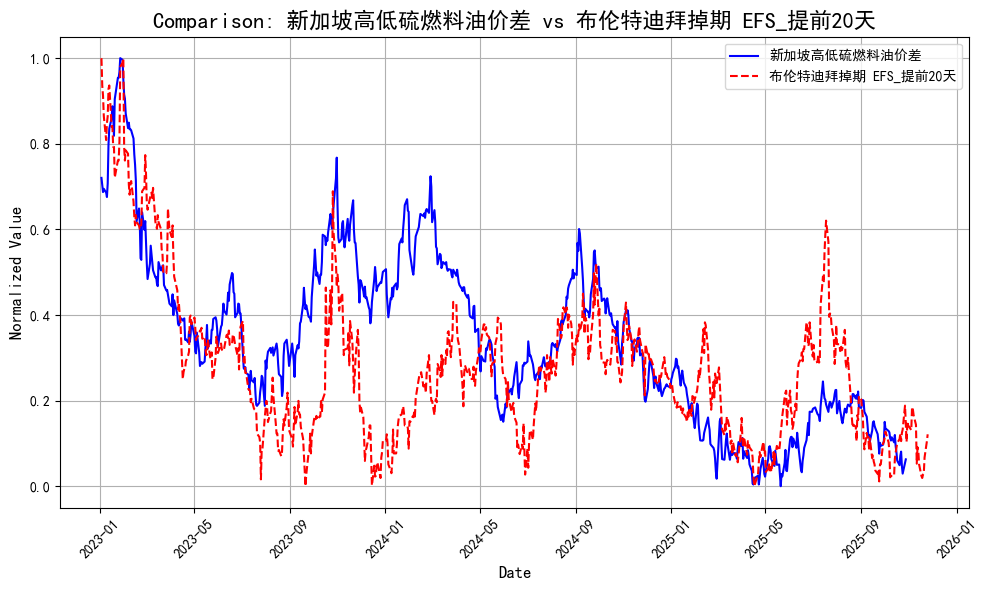

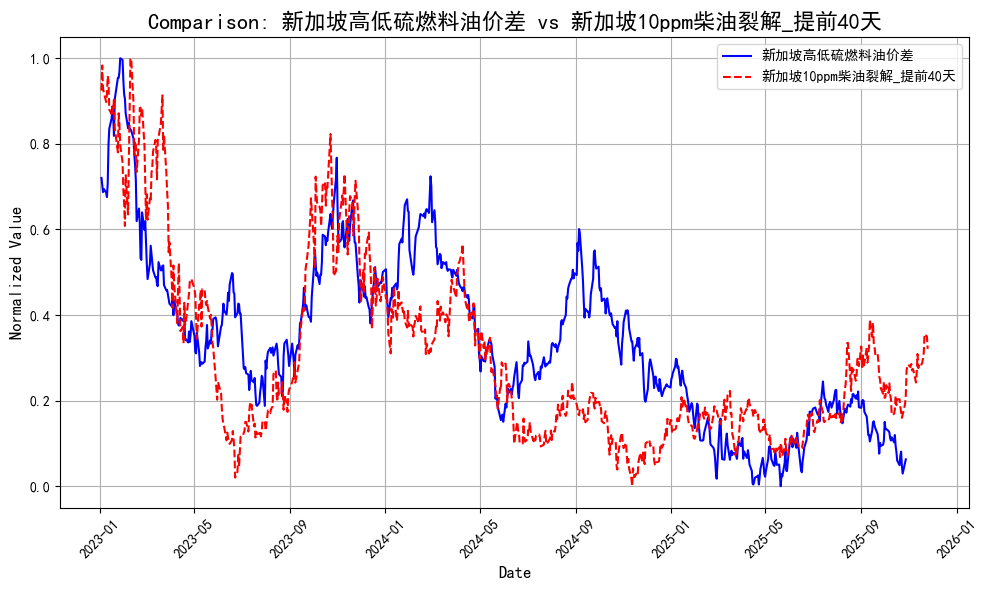

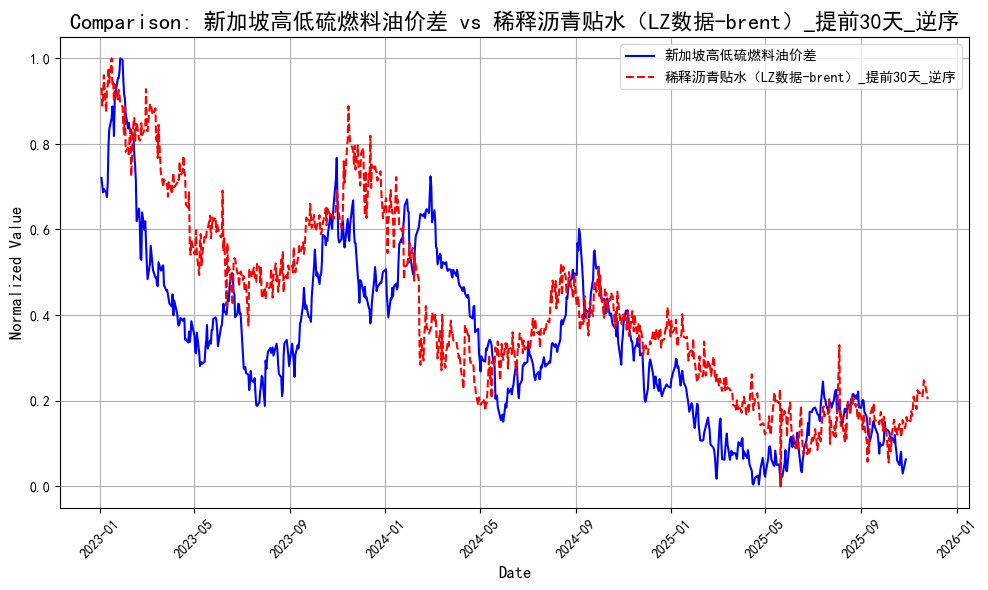

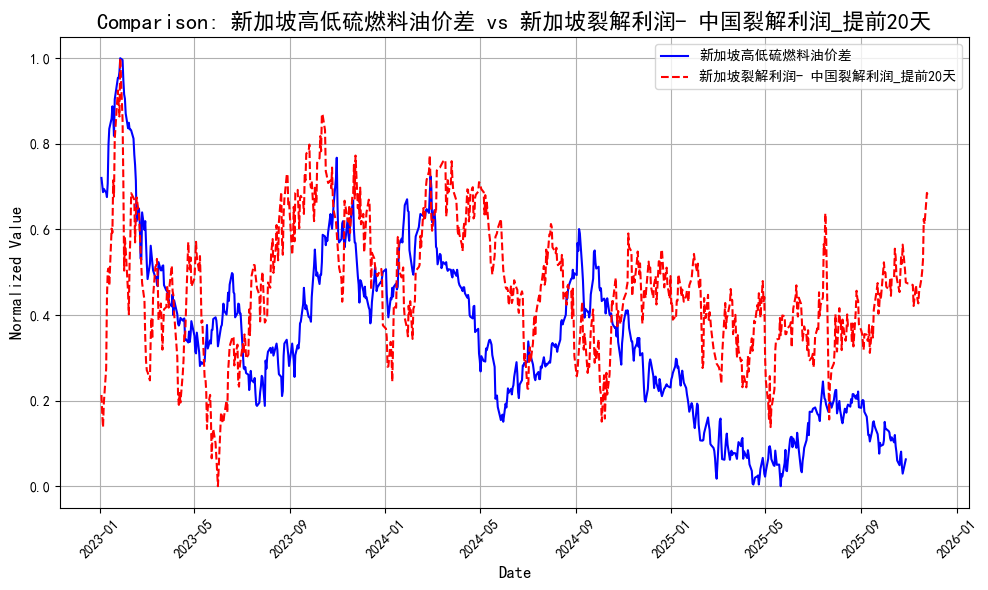

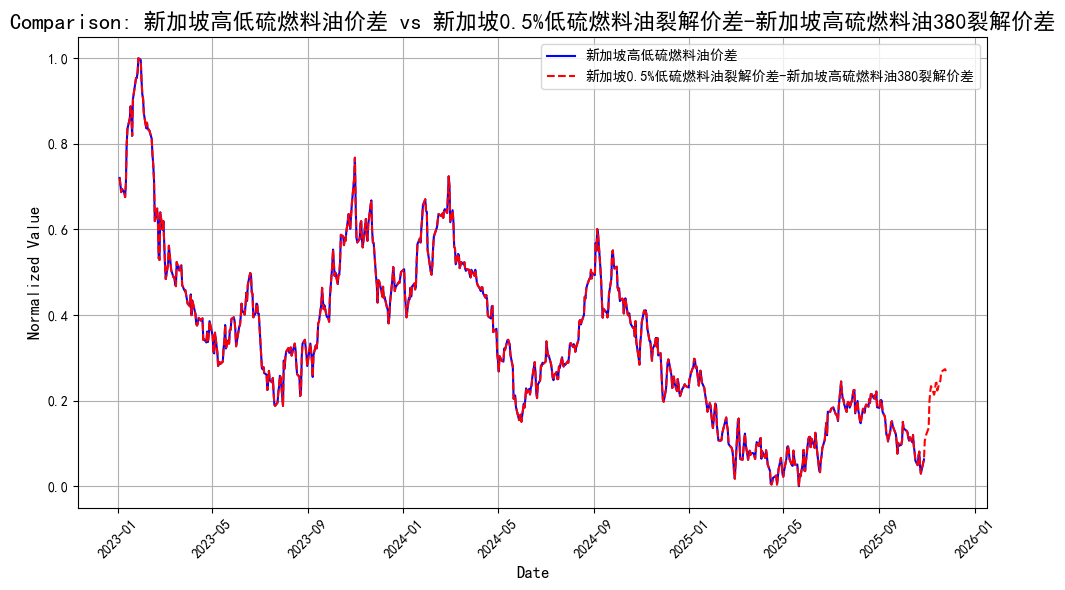

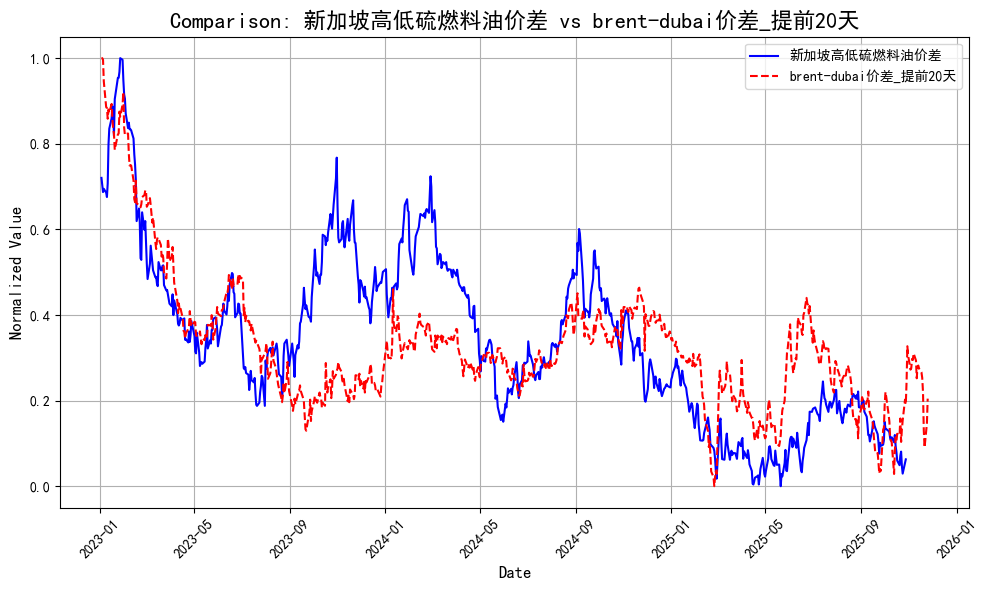

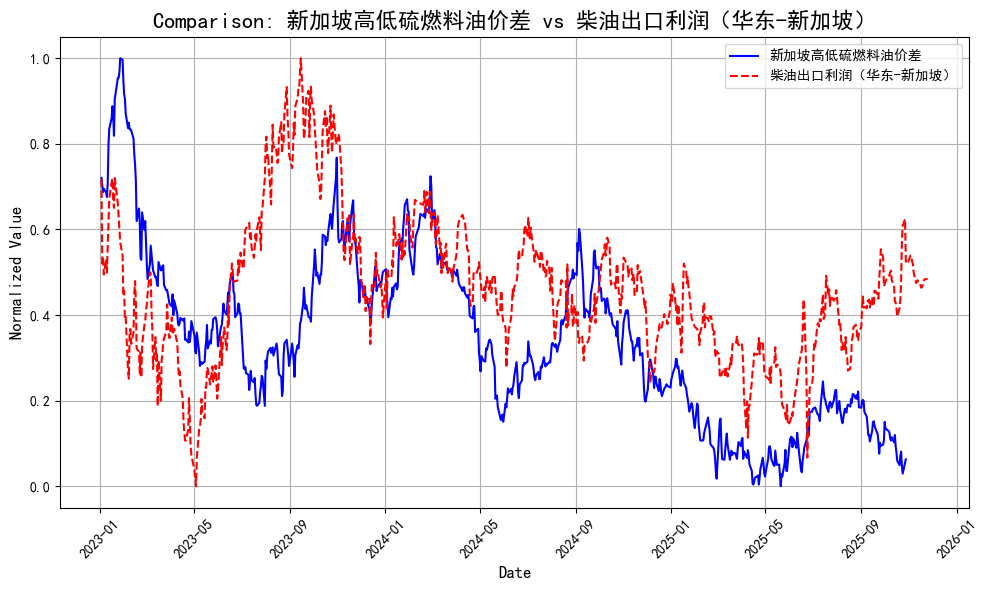

In [12]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='新加坡高低硫燃料油价差', 
    compare_cols=[
        '布伦特迪拜掉期 EFS_提前20天',
        '新加坡10ppm柴油裂解_提前40天',
        '稀释沥青贴水（LZ数据-brent）_提前30天_逆序',
        '新加坡裂解利润- 中国裂解利润_提前20天',
        '新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差',
        'brent-dubai价差_提前20天',
        '柴油出口利润（华东-新加坡）',
        ]
)

In [13]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 21
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '布伦特迪拜掉期 EFS_提前20天',
        '新加坡10ppm柴油裂解_提前40天',
#        '稀释沥青贴水（LZ数据-brent）_提前30天_逆序',
        '新加坡裂解利润- 中国裂解利润_提前20天',
        '新加坡0.5%低硫燃料油裂解价差-新加坡高硫燃料油380裂解价差',
        'brent-dubai价差_提前20天',
        '柴油出口利润（华东-新加坡）',
]

predict_column = '新加坡高低硫燃料油价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.019076895067287096, 
    'max_depth': 7, 
    'min_child_weight': 1.9983231410186746, 
    'subsample': 0.8915228866126468, 
    'colsample_bytree': 0.9633030498557493, 
    'gamma': 0.04016694339000221, 
    'reg_alpha': 0.003933350939645253, 
    'reg_lambda': 1.7903681660674629,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:48.00990	train-rmse:35.65942


[500]	eval-rmse:1.69922	train-rmse:0.30558


[999]	eval-rmse:1.59193	train-rmse:0.16937


训练集 MSE (DMatrix): 0.035, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 2.5343, 测试集 R² (DMatrix): 0.9404


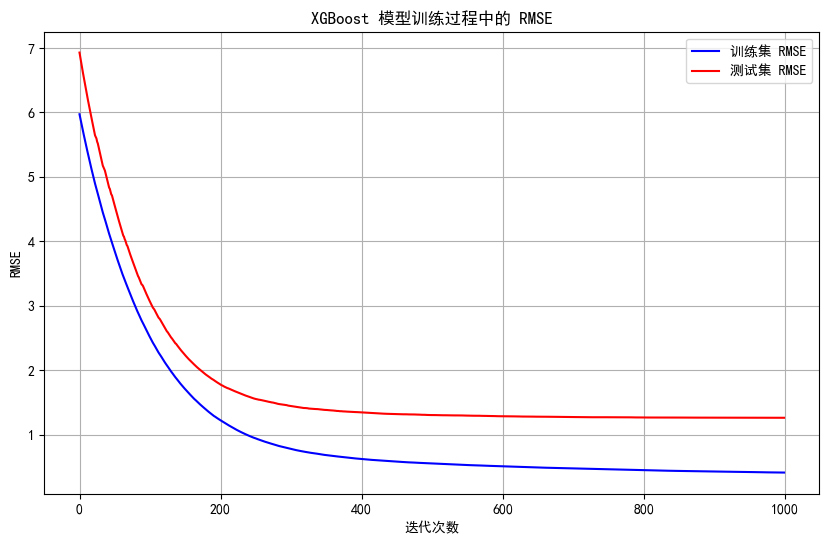

In [14]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:36.01628


[500]	train-rmse:0.31447


[999]	train-rmse:0.17836


全部数据 MSE: 0.039, 全部数据 R²: 1.0


Gap between last actual value and first prediction: -12.256028137207032


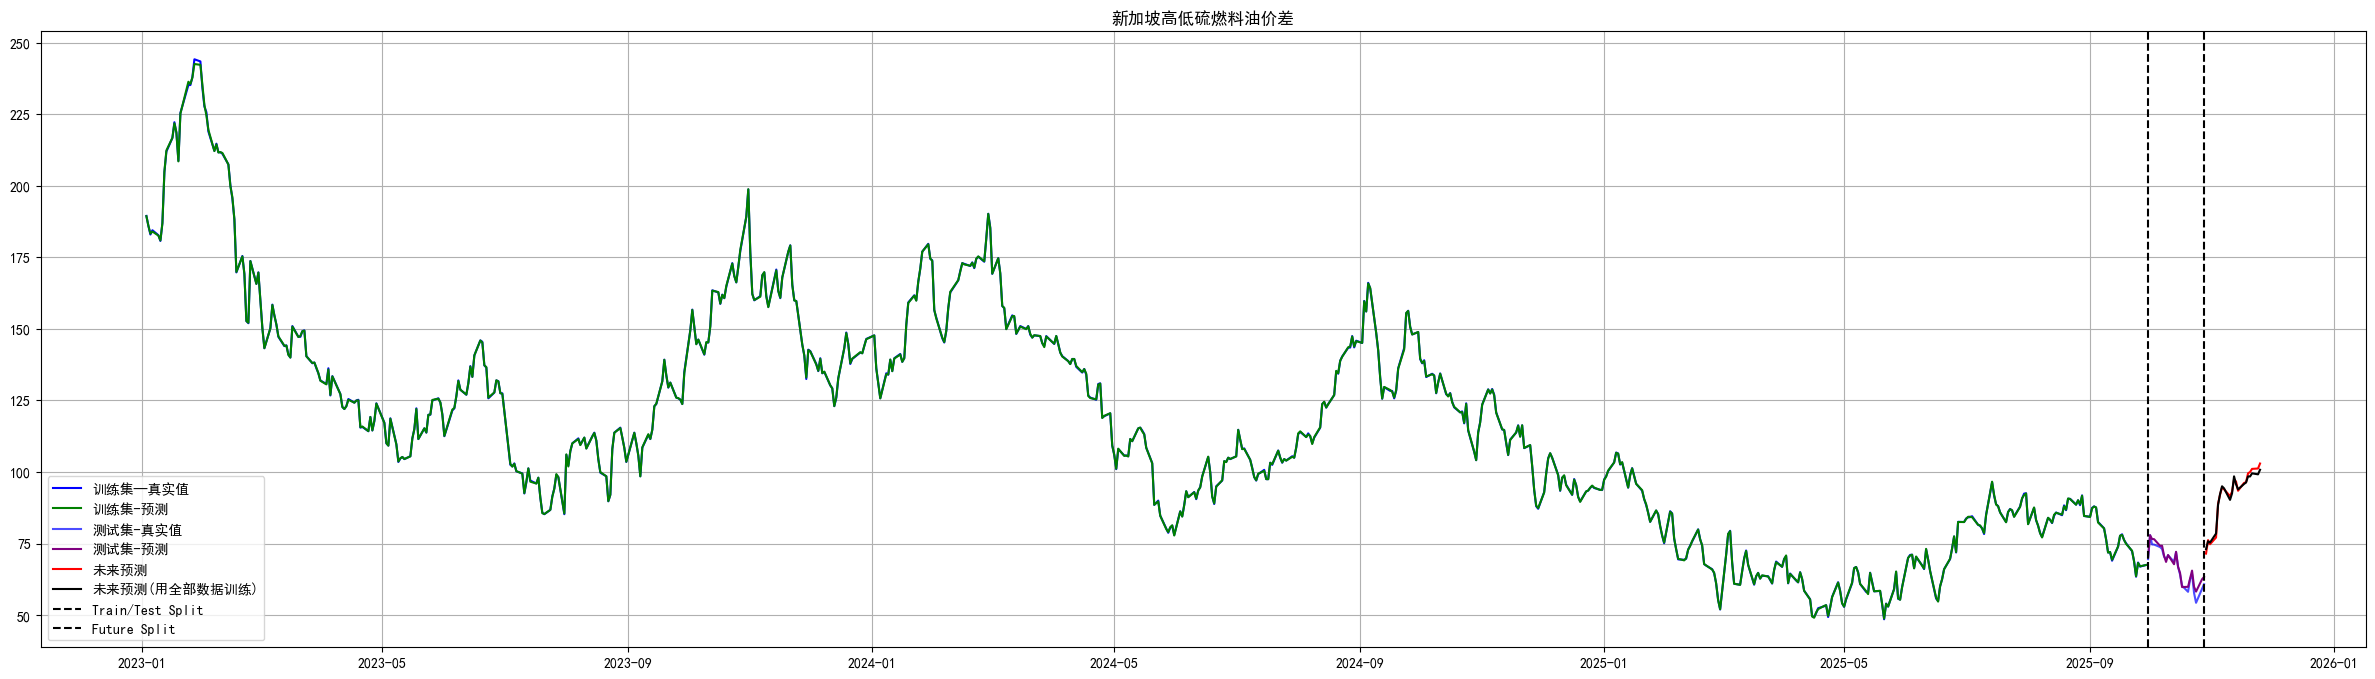

In [16]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('新加坡高低硫燃料油价差')
plt.legend()
plt.grid(True)
plt.show()

---

In [17]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/新加坡高低硫燃料油价差_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
743,2025/11/25,NaN,100.779839
742,2025/11/24,NaN,99.179176
741,2025/11/21,NaN,99.524460
740,2025/11/20,NaN,98.427177
739,2025/11/19,NaN,98.467308
...,...,...,...
4,2023/01/09,182.75,NaN
3,2023/01/06,184.50,NaN
2,2023/01/05,183.00,NaN
1,2023/01/04,186.00,NaN


In [18]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/新加坡高低硫燃料油价差_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,94.584419
33,2025/10/31,66.674000,68.570503
32,2025/09/30,75.349091,75.362335
31,2025/08/31,85.442381,85.471390
30,2025/07/31,86.262609,86.249710
29,2025/06/30,68.884762,68.894989
28,2025/05/31,58.726818,58.735435
27,2025/04/30,57.809091,57.794857
26,2025/03/31,66.535714,66.533356
25,2025/02/28,70.890500,70.886124


In [19]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.燃料油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "新加坡高低硫燃料油价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [20]:
from Lcel import update_excel_data
file_path = "eta/1.燃料油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "新加坡高低硫燃料油价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
